In [3]:
from sklearn.datasets import fetch_mldata
import numpy as np
import pandas as pd

In [4]:
mnist = fetch_mldata('MNIST original')

In [5]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [6]:
X, y = mnist['data'], mnist['target']

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

#### check image

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [10]:
some_digit=X[36000]

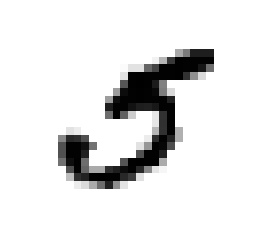

In [11]:
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation= "nearest")
plt.axis('off')
plt.show()

In [12]:
y[36000]

5.0

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],  y[:60000], y[60000:]

In [14]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Binary Classifier with using SGD(Stochastic Gradient Descent)

In [15]:
y_train_5 = (y_train ==5 )
y_test_5 = (y_test ==5 )

In [16]:
y_train_5.shape

(60000,)

In [17]:
y_test_5.shape

(10000,)

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
sgd_clf = SGDClassifier(max_iter=5, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [20]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

#### 성능 측정

아래는 직접 cross validation 구현하는 방법임

In [21]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

In [22]:
skfolds = StratifiedKFold(n_splits=3, random_state = 42)

In [23]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

    
#별거 아님 그냥 fold만들고 하나씩 수행하면서 accuracy 체크 하는 것    

0.9658
0.95395
0.94925


다시 책으로

In [24]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3 , scoring="accuracy")

array([ 0.9658 ,  0.95395,  0.94925])

모든 이미지를 무조건 5가 아니라고 예측하는 분류기를 만들어 보자

In [25]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(x), 1), dtype=bool)

In [26]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### 오차행렬

In [27]:
from sklearn.model_selection import cross_val_predict

In [28]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv =3)

In [29]:
y_train_pred

array([False, False, False, ...,  True, False, False], dtype=bool)

In [30]:
y_train_pred.shape

(60000,)

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
confusion_matrix(y_train_5, y_train_pred)

array([[53592,   987],
       [ 1633,  3788]])

위 결과를 보면<br>
53681개의 5가 아닌걸 5가 아니라고 분류했고,<br>
898개를 5가 아닌데 5라고 분류했음. <br>
2003개는 5인데 5가 아니라고 분류했고, <br>
3418개를 5인데 5라고 분류했다는 뜻. 

### 정밀도와 재현율<br>
정밀도 : 5라고 예측한 것 중 진짜 5의 비율<br>
재현율 : 진짜 5들 중에 실제 5라고 예측된 비율

In [33]:
from sklearn.metrics import precision_score, recall_score

In [34]:
# 이렇게 함수만 쓰고 실제 y랑 y hat 값만 주면 알아서 계산해 줌. 
precision_score(y_train_5, y_train_pred)

0.79329842931937178

In [35]:
recall_score(y_train_5, y_train_pred)

0.6987640656705405

F점수는 정밀도와 재현율을 하나로 합쳐줌

In [36]:
from sklearn.metrics import f1_score

In [37]:
f1_score(y_train_5, y_train_pred)

0.74303648489603757

In [38]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 54568.13315481])

In [39]:
threshold=0

In [40]:
y_some_digit_pred=(y_scores>threshold)

In [41]:
y_some_digit_pred

array([ True], dtype=bool)

In [42]:
threshold =20000
y_some_digit_pred = (y_scores >threshold )
y_some_digit_pred

array([ True], dtype=bool)

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [44]:
y_scores #점수를 리턴함. 

array([-561435.63167221, -198228.9988034 , -403097.62999062, ...,
        409307.67927066,  -12505.36457531, -436139.76076633])

In [45]:
from sklearn.metrics import precision_recall_curve

In [46]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [47]:
precisions

array([ 0.09126109,  0.09124579,  0.09124733, ...,  1.        ,
        1.        ,  1.        ])

In [48]:
recalls

array([  1.00000000e+00,   9.99815532e-01,   9.99815532e-01, ...,
         3.68935621e-04,   1.84467810e-04,   0.00000000e+00])

In [49]:
thresholds

array([-1575740.20653967, -1575245.1033611 , -1574983.62631355, ...,
         945372.48556322,   999719.57186713,  1081553.95910288])

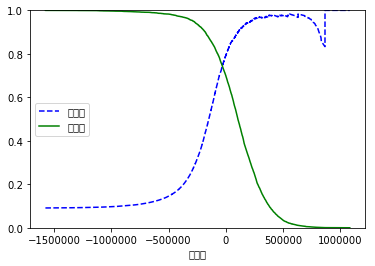

In [50]:
def plot_precision_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.xlabel("임계값")
    plt.legend(loc='center left')
    plt.ylim([0, 1])
    
plot_precision_vs_threshold(precisions, recalls, thresholds)

In [51]:
#표 보고 임계값을 70000으로 주는거지
y_train_pred_90 = (y_scores>70000)
y_scores>70000

array([False, False, False, ...,  True, False, False], dtype=bool)

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.87017741481272881

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.57000553403431098

### ROC 곡선

In [54]:
from sklearn.metrics import roc_curve

In [55]:
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [56]:
fpr

array([  0.00000000e+00,   0.00000000e+00,   1.83220653e-05, ...,
         9.89025083e-01,   9.89025083e-01,   1.00000000e+00])

In [57]:
tpr

array([  1.84467810e-04,   9.22339052e-04,   9.22339052e-04, ...,
         9.99815532e-01,   1.00000000e+00,   1.00000000e+00])

<function matplotlib.pyplot.show(*args, **kw)>

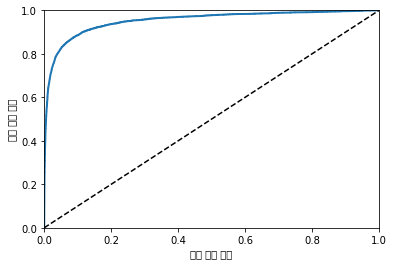

In [58]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율')
    plt.ylabel('진짜 양성 비율')
    
plot_roc_curve(fpr, tpr)    
plt.show

좋은 분류기는 직선과 가운데 점선 사이의 거리가 멀어야 함<br>
그 척도로서 곡선 아래 면적을 계산함

In [59]:
from sklearn.metrics import roc_auc_score

In [60]:
roc_auc_score(y_train_5, y_scores)

0.95283888571843833

In [61]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [62]:
y_probas_forest
# 1행은 양성일 확률, 2행은 음성일 확률

array([[ 1. ,  0. ],
       [ 1. ,  0. ],
       [ 0.9,  0.1],
       ..., 
       [ 0. ,  1. ],
       [ 1. ,  0. ],
       [ 1. ,  0. ]])

In [63]:
# 양성 클래스의 확률을 점수로 사용하자
y_scores_forest = y_probas_forest[:, 1]

In [64]:
y_scores_forest

array([ 0. ,  0. ,  0.1, ...,  1. ,  0. ,  0. ])

In [65]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [66]:
fpr_forest

array([  0.00000000e+00,   5.49661958e-05,   2.01542718e-04,
         6.04628154e-04,   1.30086663e-03,   3.00481870e-03,
         6.77916415e-03,   1.62883160e-02,   4.55120101e-02,
         1.63689331e-01,   1.00000000e+00])

In [67]:
tpr_forest

array([ 0.27670172,  0.48551928,  0.63715182,  0.74635676,  0.82696919,
        0.88673676,  0.92381479,  0.957019  ,  0.97749493,  0.99243682,  1.        ])

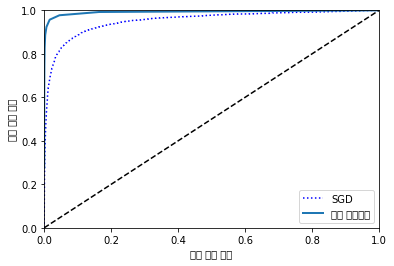

In [68]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [69]:
roc_auc_score(y_train_5, y_scores_forest)

0.99256472948900298

### 다중 분류

In [70]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [71]:
sgd_clf.predict([some_digit])

array([ 5.])

In [72]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [73]:
some_digit_scores

array([[-119535.07073165, -474790.64397118, -335730.70493879,
        -146381.50266554, -388384.54993558,   54568.13315481,
        -784244.03776326, -548656.07201082, -600582.3469131 ,
        -869377.17234427]])

In [74]:
# 점수 가장 높은 클라스로 분류 -> argmax 쓰면 가장 높은 놈의 index를 줌
np.argmax(some_digit_scores)

5

In [75]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [76]:
sgd_clf.classes_[5]

5.0

원래는 사이킷런이 OvO, OvA를 선택해서 하는데 <br>
강제로 하게 만들 수도 있음

In [77]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [78]:
len(ovo_clf.estimators_) # 45번이나 돌리고 있다는 소리임. 

45

In [79]:
#random forest 
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [80]:
#각 클래스별로 부여한 확률을 볼 수 있음. 
forest_clf.predict_proba([some_digit])

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [81]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87092581,  0.8639932 ,  0.83967595])

In [82]:
#간단한 튜닝으로 성능 높일 수 있음 

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()
X_train_Scaled = scaler.fit_transform(X_train.astype(np.float64))

In [85]:
cross_val_score(sgd_clf, X_train_Scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91186763,  0.90754538,  0.90813622])

In [86]:
y_train_pred = cross_val_predict(sgd_clf, X_train_Scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [87]:
conf_mx

array([[5740,    2,   24,   10,   12,   39,   46,    9,   37,    4],
       [   1, 6469,   49,   25,    6,   46,    8,   12,  115,   11],
       [  58,   37, 5341,   95,   82,   25,   93,   59,  155,   13],
       [  47,   41,  149, 5310,    2,  255,   42,   49,  137,   99],
       [  20,   24,   39,    7, 5347,   10,   57,   27,   92,  219],
       [  68,   39,   38,  177,   76, 4606,  115,   28,  177,   97],
       [  29,   18,   53,    2,   42,   88, 5636,    6,   44,    0],
       [  21,   21,   71,   28,   60,   12,    6, 5780,   14,  252],
       [  54,  157,   70,  155,   15,  156,   57,   23, 5022,  142],
       [  47,   33,   27,   81,  162,   35,    2,  175,   87, 5300]])

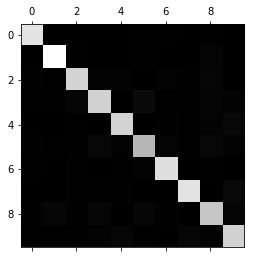

In [88]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교해보자

In [89]:
row_sums=conf_mx.sum(axis=1, keepdims=True)

In [90]:
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [91]:
norm_conf_mx = conf_mx/ row_sums

In [92]:
norm_conf_mx

array([[  9.69103495e-01,   3.37666723e-04,   4.05200068e-03,
          1.68833361e-03,   2.02600034e-03,   6.58450110e-03,
          7.76633463e-03,   1.51950025e-03,   6.24683437e-03,
          6.75333446e-04],
       [  1.48323939e-04,   9.59507565e-01,   7.26787303e-03,
          3.70809849e-03,   8.89943637e-04,   6.82290122e-03,
          1.18659152e-03,   1.77988727e-03,   1.70572530e-02,
          1.63156333e-03],
       [  9.73481034e-03,   6.21013763e-03,   8.96441759e-01,
          1.59449480e-02,   1.37630077e-02,   4.19603894e-03,
          1.56092649e-02,   9.90265190e-03,   2.60154414e-02,
          2.18194025e-03],
       [  7.66595988e-03,   6.68732670e-03,   2.43027239e-02,
          8.66090360e-01,   3.26211059e-04,   4.15919100e-02,
          6.85043223e-03,   7.99217093e-03,   2.23454575e-02,
          1.61474474e-02],
       [  3.42348511e-03,   4.10818213e-03,   6.67579596e-03,
          1.19821979e-03,   9.15268744e-01,   1.71174255e-03,
          9.75693256e-03

In [93]:
np.fill_diagonal(norm_conf_mx, 0)
#대각선만 0으로 채ㅜㅇ기

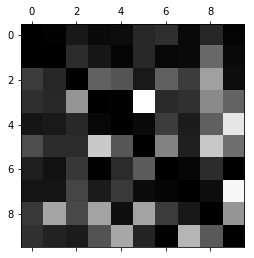

In [94]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

### 다중 레이블 분류<br>
한 사진에서 한명만 꼽아내는게 아니고<br>
한 사진에도 여러개가 들어있을 수 있잖아.

In [95]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train %2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [96]:
y_multilabel

array([[False, False],
       [False,  True],
       [False, False],
       ..., 
       [False,  True],
       [False, False],
       [False,  True]], dtype=bool)

In [97]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs=1)

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

### 다중 출력 분류

In [ ]:
noise = rnd.randint(0, 100, len(X_train), 784)
X_train_mod = X_train+noise
noise=rand.randint(0, 100, (len(X_test)), 784)
X_test_mod = X_test+noise
y_train_mode = X_Train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)